In [6]:
!pip install onnx
!pip install onnxscript
!pip install onnxruntime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 58.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 5.6 MB/s eta 0:00:00


In [7]:
import torch
from torch import nn
import torch.nn.functional as F
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import time
import numpy as np
import matplotlib.pyplot as plt
import onnx
import onnxruntime

In [9]:
#Chuẩn bị dữ liệu MNIST
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,),(0.5,))
])

trainset = torchvision.datasets.MNIST(root='./data',train=True, download = True, transform = transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size = 64, shuffle = True)
testset = torchvision.datasets.MNIST(root="./data",train=False, download = True, transform = transform)
testloader = torch.utils.data.DataLoader(testset, batch_size = 64, shuffle = True)

In [10]:
class CNN(nn.Module):
  def __init__(self):
    super(CNN,self).__init__()
    self.conv1 = nn.Conv2d(1,32, kernel_size = 3, padding = 1)
    self.conv2 = nn.Conv2d(32,64, kernel_size = 3, padding = 1)
    self.fc1 = nn.Linear(64 * 7 * 7, 128)
    self.fc2 = nn.Linear(128,10)
    self.pool = nn.MaxPool2d(2,2)

  def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

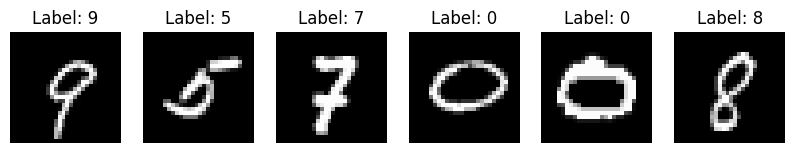

In [14]:
import matplotlib.pyplot as plt

dataiter = iter(trainloader)
images, labels = next(dataiter)

fig, axes = plt.subplots(1,6, figsize = (10,3))
for i in range(6):
  img = images[i].numpy().squeeze()
  axes[i].imshow(img, cmap='gray')
  axes[i].set_title(f'Label: {labels[i].item()}')
  axes[i].axis('off')
plt.show()


In [15]:
model = CNN()
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr = 0.001)

epochs = 5
print("Training")
for epoch in range(epochs):
  for images, labels in trainloader:
    optimizer.zero_grad()
    outputs = model(images)
    loss = loss_fn(outputs, labels)
    loss.backward()
    optimizer.step()
print("Training Completed!")

Training
Training Completed!


In [16]:
#Inference with Pytorch
model.eval()
images, labels = next(iter(testloader))
start_time = time.time()
with torch.no_grad():
  outputs = model(images)
pytorch_time = time.time() - start_time
predicted = torch.argmax(outputs, dim = 1)

In [17]:
torch.onnx.export(model, images, "mnist_cnn.onnx", input_names=['input'], output_names=['output'])
print("Model exported to ONNX")

#Chạy inference with ONNX
onnx_session = onnxruntime.InferenceSession("mnist_cnn.onnx")
onnx_inputs = {onnx_session.get_inputs()[0].name: images.numpy()}
start_time = time.time()
onnx_outputs = onnx_session.run(None, onnx_inputs)
onnx_time = time.time() - start_time
onnx_predicted = np.argmax(onnx_outputs[0], axis=1)

Model exported to ONNX


PyTorch inference time: 0.031522 seconds
ONNX inference time: 0.008102 seconds


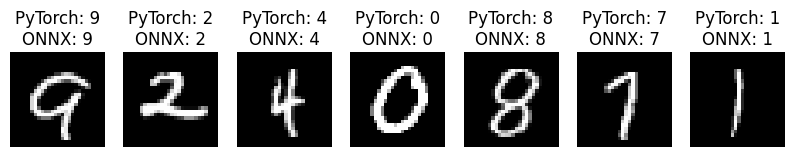

In [21]:
print(f"PyTorch inference time: {pytorch_time:.6f} seconds")
print(f"ONNX inference time: {onnx_time:.6f} seconds")

fig, axes = plt.subplots(1, 7, figsize=(10, 2))
for i in range(7):
    axes[i].imshow(images[i][0], cmap='gray')
    axes[i].set_title(f"PyTorch: {predicted[i].item()}\nONNX: {onnx_predicted[i]}")
    axes[i].axis('off')
plt.show()
